<a href="https://colab.research.google.com/github/Joseluismed/Examen1_Solitones_JLMG/blob/main/Examen1_Solitones_JLMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecuación KdV utilizando diferencias finitas

Módulo utilizado:

In [21]:
%%writefile kdv_diferenciasfinitas.py

#Ecuación KdV utilizando diferencias finitas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
class EcuacionKdVdiffin:
  def __init__(self,longitud,tiempo,dx,dt):
    self.longitud = longitud    #Longitud espacial
    self.tiempo = tiempo        #Intervalo temporal
    self.dx = dx
    self.dt = dt
    self.nx = int(longitud/dx)      #Definición de numero de puntos en espacio
    self.nt = int(tiempo/dt)      #Definición de numero de puntos en tiempo
    self.u = np.zeros((self.nt,self.nx))    #Definición de arreglo solución u(x,t)
    self.x=np.linspace(-self.longitud/2,self.longitud/2,self.nx)
    self.t=np.linspace(0,self.tiempo,self.nt)

  def condiciones_iniciales(self,funcion):    #Aplicando la condición inicial a u[0,:] con la función especificada
    for i in range(self.nx):
      self.u[0,i] = funcion(self.x[i])    #u[Tiempo, Espacio]

  def solucion(self,funcionderivada):     #Resolviendo la ecuación diferencial con diferencias finitas  donde funcionderivada es la derivada de la condición inicial respecto de x
    for i in range(self.nx):
      self.u[1,i]=self.u[0,i] + funcionderivada(self.x[i])*0.01

    for n in range(1,self.nt-1):
      for i in range(2,self.nx-2):
        self.u[n+1,i]=self.u[n-1,i]-6*(self.dt/(2*self.dx**2))*self.u[n,i]*(self.u[n,i+1]-self.u[n,i-1])-(self.dt/(2*self.dx**3))*(self.u[n,i+2]-2*self.u[n,i+1]+2*self.u[n,i-1]-self.u[n,i-2])
      self.u[n+1,0]=self.u[n+1,-1]=0
    return self.u

  def grafica(self):
    for h in range(0, self.nt, self.nt // 5):  # Graficar 5 curvas cada cierto intervalo regular de tiempo
        plt.plot(self.x, self.u[h, :], label=f"t = {h*self.dt:.3f}")
    plt.xlabel('x')
    plt.ylabel(r'$\phi(t, x)$')
    plt.title(r'Evolución ecuación KdV (diferencias finitas)')
    plt.legend()
    plt.show()

  def grafica_3d(self):         #Gráfica 3D de x vs t vs u(x,t)
        X, T = np.meshgrid(self.x, self.t)  # Crear mallas para x y t
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, T, self.u, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel(r'$\phi(t, x)$')
        ax.set_title(r'Evolución 3D de la ecuación KdV')
        plt.show()



Overwriting kdv_diferenciasfinitas.py


Utilizando el módulo para resolver las ecuaciones KdV


## Solitón en KdV



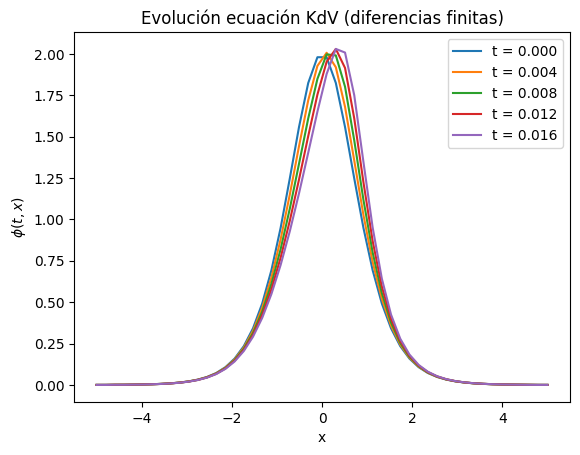

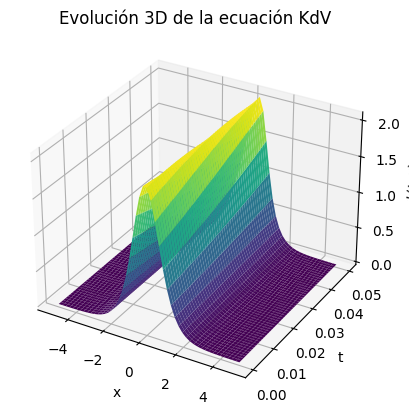

In [22]:
import kdv_diferenciasfinitas as kdvdf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Resolviendo la ecuacion diferencial con la primera condición inicial
ecuacionKdV=kdvdf.EcuacionKdVdiffin(longitud=10,tiempo=0.02,dx=0.2,dt=0.000001)
ecuacionKdV.condiciones_iniciales(funcion=lambda x: 2*(1/(np.cosh(x)**2)))
u=ecuacionKdV.solucion(funcionderivada=lambda x:-4*(1/np.cosh(x)**2)*np.tanh(x))
ecuacionKdV.grafica()
ecuacionKdV.grafica_3d()

## 2 Solitones en KdV

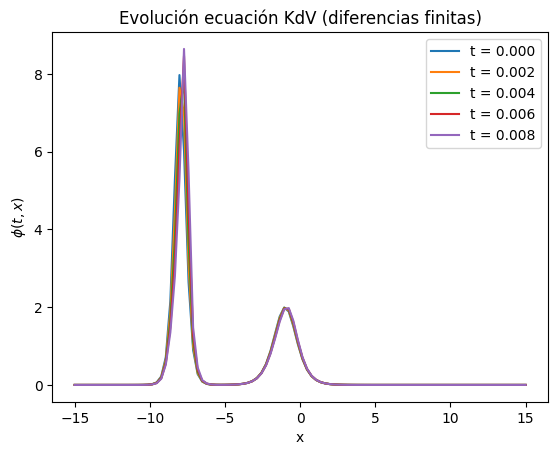

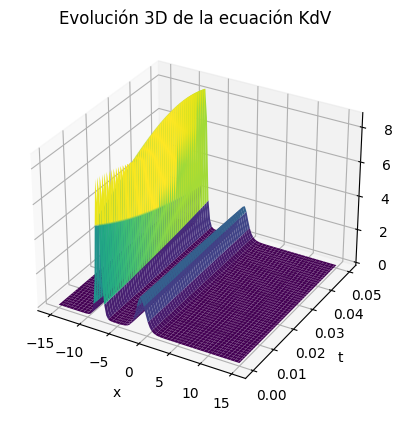

In [23]:
import kdv_diferenciasfinitas as kdvdf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Resolviendo la ecuación diferencial con la segunda condición inicial
ecuacionKdV=kdvdf.EcuacionKdVdiffin(longitud=30,tiempo=0.01,dx=0.3,dt=0.000001)
ecuacionKdV.condiciones_iniciales(funcion=lambda x: 8*(1/(np.cosh(2*x + 16)**2)) + 2*(1/np.cosh(x + 1)**2))
u=ecuacionKdV.solucion(funcionderivada=lambda x:-32*(1/np.cosh(2*x+16))**2*np.tanh(2*x+16)-4*(1/np.cosh(x+1)**2)*np.tanh(x+1))
ecuacionKdV.grafica()
ecuacionKdV.grafica_3d()

# Ecuación KdV utilizando un método pseudoespectral (transformada rápida de Fourier y Euler)

Módulo utilizado:

In [19]:
%%writefile kdv_ifft.py
import numpy as np
import matplotlib.pyplot as plt

class EcuacionKdV_Pseudoespectral:
    def __init__(self, longitud, tiempo, nx, dt):
        self.longitud = longitud
        self.tiempo = tiempo
        self.nx = nx  # Número de puntos en la malla
        self.dt = dt
        self.nt = int(tiempo / dt)
        # Definiendo malla espacial y frecuencias en Fourier
        self.x = np.linspace(-longitud / 2, longitud / 2, nx, endpoint=False)
        self.k = (2 * np.pi / longitud) * np.fft.fftfreq(nx) * nx  # Frecuencias en Fourier
        self.u = np.zeros((self.nt, self.nx))  # Definiendo el arreglo de la solución u(x,t)

    def condiciones_iniciales(self, funcion):
        # Definiendo las condiciones iniciales
        self.u[0, :] = funcion(self.x)

    def solucion(self):
        # Transformada de Fourier inicial
        u_hat = np.fft.fft(self.u[0, :])  #Pasando al dominio de la frecuencia usando la transformada de Fourier fft

        # Evolución temporal
        for n in range(self.nt - 1):
            # Derivadas en el dominio de Fourier
            u = np.fft.ifft(u_hat)  # Volver al dominio espacial para el término no lineal utilizando la transformada inversa de Fourier ifft
            u_x = np.fft.ifft(1j * self.k * u_hat)  # u_x en el dominio espacial usando ifft
            u_xxx = np.fft.ifft((1j * self.k) ** 3 * u_hat)  # u_xxx en el dominio espacial usando ifft

            # Avanzando en el tiempo usando el método de Euler
            u_hat = u_hat - self.dt * np.fft.fft(6 * u.real * u_x.real + u_xxx.real)

            # Guardando la solución en el dominio real ya que es la solución física que nos interesa
            self.u[n + 1, :] = np.fft.ifft(u_hat).real

        return self.u

    def grafica(self):
        # Graficando 5 curvas espaciadas por un cierto intervalo de tiempo
        plt.figure(figsize=(10, 6))
        for n in range(0, self.nt, self.nt // 5):
            plt.plot(self.x, self.u[n, :], label=f"t = {n * self.dt:.2f}")
        plt.xlabel("x")
        plt.ylabel(r"$u(x, t)$")
        plt.title("Evolución de la ecuación KdV (Pseudoespectral)")
        plt.legend()
        plt.show()

    def grafica_3d(self):
        # Crear la malla de tiempo y espacio para la gráfica 3D
        t = np.linspace(0, self.tiempo, self.nt)
        X, T = np.meshgrid(self.x, t)

        # Gráfica en 3D de x vs t vs u(x,t)
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, T, self.u, cmap='viridis', edgecolor='none')

        ax.set_xlabel("x")
        ax.set_ylabel("t")
        ax.set_zlabel("u(x, t)")
        ax.set_title("Evolución de la ecuación KdV en 3D")
        plt.show()


Overwriting kdv_ifft.py


Utilizando el módulo para resolver las ecuaciones KdV

## Solitón en KdV

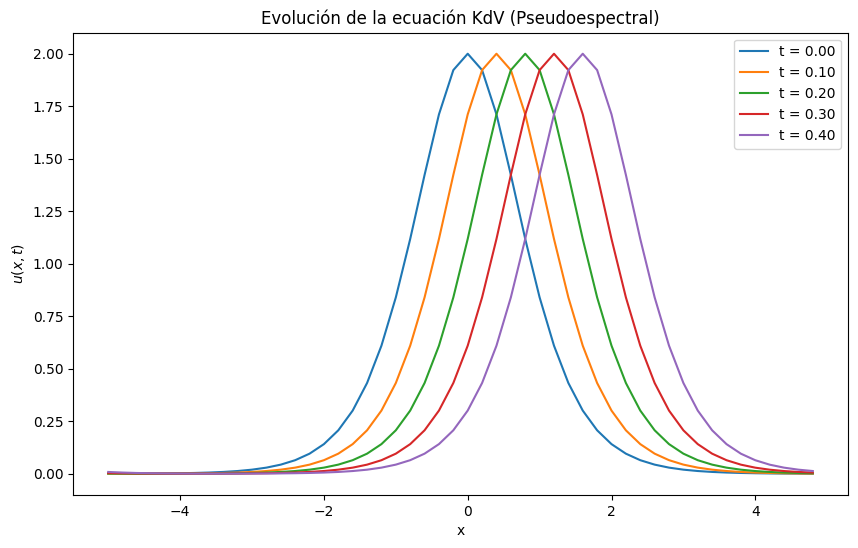

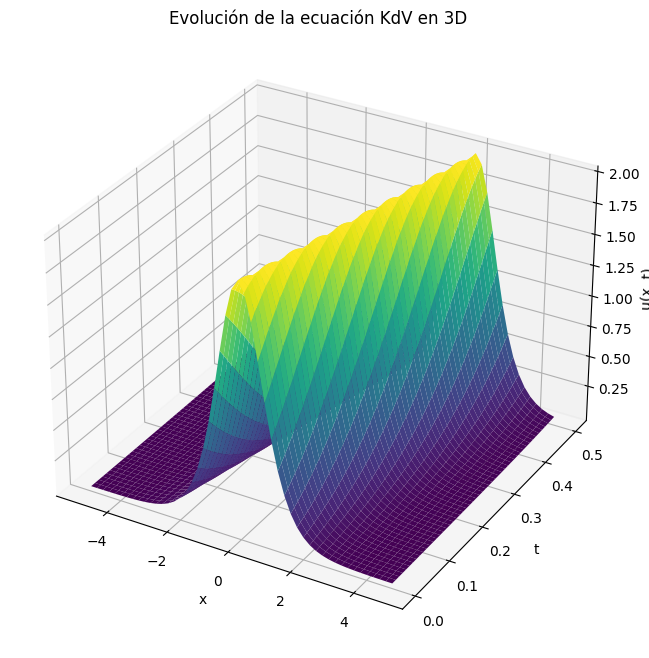

In [20]:
import kdv_ifft as kdvF
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def condicion_inicial(x):
    return 2 * (1 / np.cosh(x) ** 2)

#Resolviendo la ecuación diferencial con la primera condición inicial
kdv_pseudoespectral = kdvF.EcuacionKdV_Pseudoespectral(longitud=10, tiempo=0.5, nx=50, dt=0.000001)
kdv_pseudoespectral.condiciones_iniciales(condicion_inicial)
kdv_pseudoespectral.solucion()
kdv_pseudoespectral.grafica()
kdv_pseudoespectral.grafica_3d()

## 2 Solitones en KdV

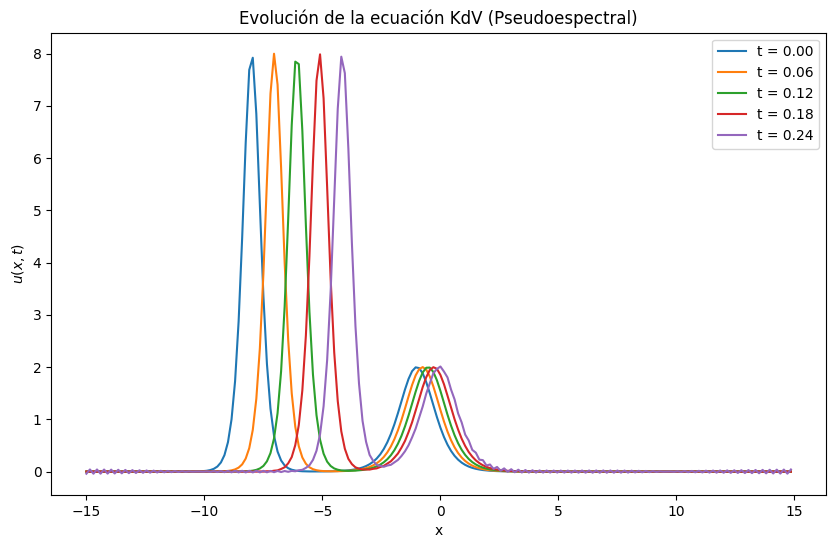

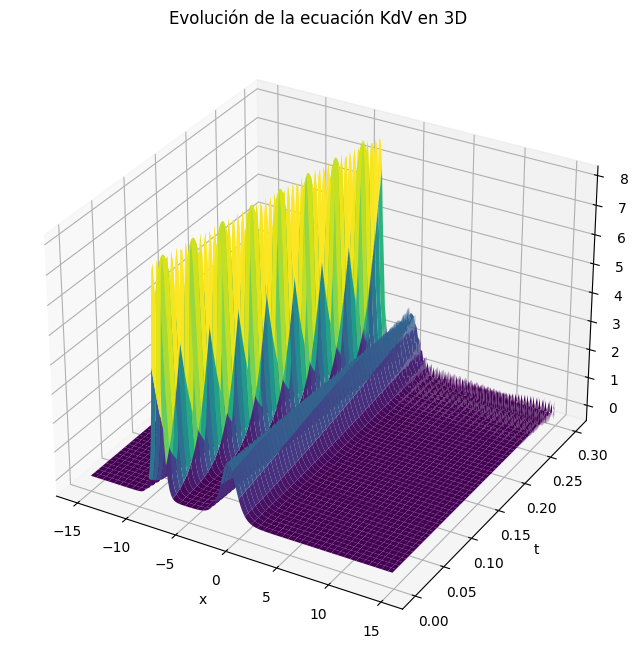

In [15]:
import kdv_ifft as kdvF
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def condicion_inicial(x):
    # Condición inicial tipo "solitón"
    return 8*(1/(np.cosh(2*x + 16)**2)) + 2*(1/np.cosh(x + 1)**2)

# Parámetros de la simulación
longitud = 30
tiempo = 0.3
nx = 200  # Número de puntos en la malla espacial
dt = 0.000001

# Crear y resolver la ecuación
kdv_pseudoespectral = kdvF.EcuacionKdV_Pseudoespectral(longitud, tiempo, nx, dt)
kdv_pseudoespectral.condiciones_iniciales(condicion_inicial)
kdv_pseudoespectral.solucion()
kdv_pseudoespectral.grafica()
kdv_pseudoespectral.grafica_3d()
